# DCGAN

First realistic GANs - using CNNs for Generator and Discriminator.



In [ ]:
# check the GPU usage
!nvidia-smi

Sun Nov 29 07:34:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

## Set up a Generator
This time, we use (transposed) CNN for the generator. <br>
In this network, batch normalization (BN) is used to surpress internal covariate shift.<br>

 input(100)-FC(7x7x256)-BN-LReLU-FC(7x7x128)-BN-LReLU-Tconv(14x14x64)-BN-LReLU-Tconv(28x28x1)-tanh-output(28x28).

In [ ]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 7x7x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=5, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    # Transposed convolution layer, from 7x7x128 into 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    # Transposed convolution layer, from 14x14x64 into 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

## Discriminator
For a generator, common CNN is used.<br>
input(28x28x1)-conv(14x14x64)-LReLU-Drop-conv(7x7x128)-LReLU-Drop-output(1)

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x64 tensor
    model.add(
        Conv2D(64, kernel_size=5, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    # Convolutional layer, from 14x14x64 into 7x7x128 tensor
    model.add(
        Conv2D(128, kernel_size=5, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## Model

In [ ]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
discriminator.summary()
generator.summary()
gan.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

## Preparation for the training

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))
    #real = np.ones((batch_size, 1))*0.9+np.random.rand(batch_size,1)*0.1

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))
    #fake = np.random.rand(batch_size,1)*0.1

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss_real[0] = d_loss_real[0]
        d_loss_fake[0] = d_loss_fake[0]
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Training the model

11493376/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.281014, acc.: 88.28%] [G loss: 2.456077]
2000 [D loss: 0.327167, acc.: 85.16%] [G loss: 2.670578]
3000 [D loss: 0.319680, acc.: 87.50%] [G loss: 2.909239]
4000 [D loss: 0.368929, acc.: 83.59%] [G loss: 2.567656]
5000 [D loss: 0.354586, acc.: 82.81%] [G loss: 2.867875]
6000 [D loss: 0.344072, acc.: 84.77%] [G loss: 2.254699]
7000 [D loss: 0.408234, acc.: 82.03%] [G loss: 2.182978]
8000 [D loss: 0.413304, acc.: 79.69%] [G loss: 2.232624]
9000 [D loss: 0.362003, acc.: 83.98%] [G loss: 2.720552]
10000 [D loss: 0.470621, acc.: 76.95%] [G loss: 2.514819]
11000 [D loss: 0.309164, acc.: 85.94%] [G loss: 2.562767]
12000 [D loss: 0.395724, acc.: 82.81%] [G loss: 2.147701]
13000 [D loss: 0.416491, acc.: 78.12%] [G loss: 2.272367]
14000 [D loss: 0.363197, acc.: 83.59%] [G loss: 1.989170]
15000 [D loss: 0.367885, acc.: 82.42%] [G loss: 2.250078]
16000 [D loss: 0.446688, acc.: 81.25%] [G loss: 1.902048]
17000 [D loss: 0

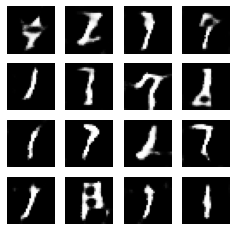

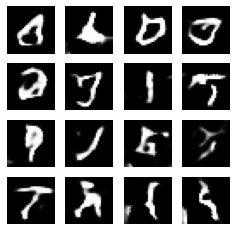

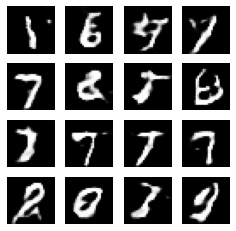

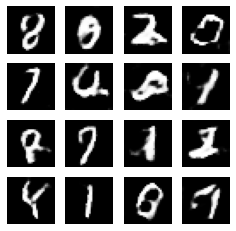

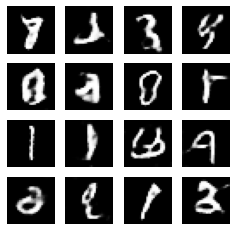

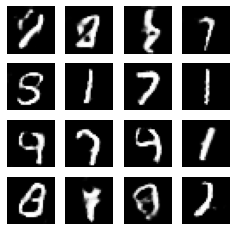

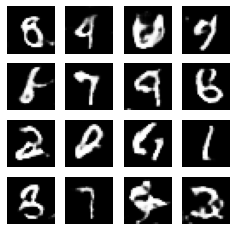

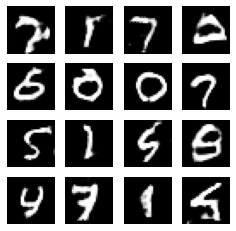

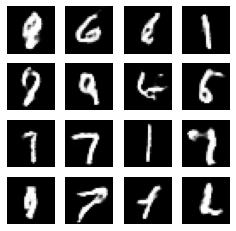

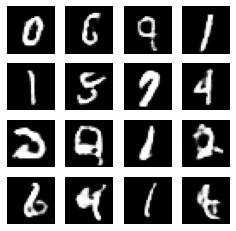

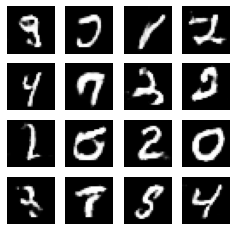

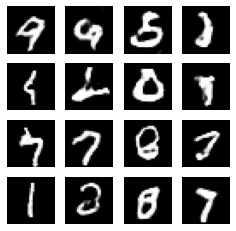

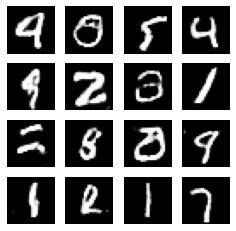

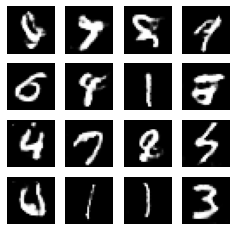

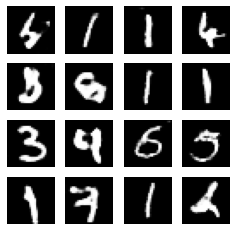

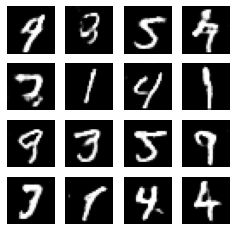

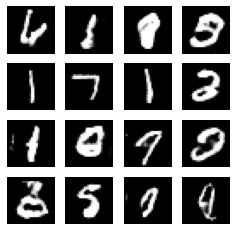

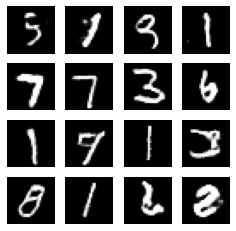

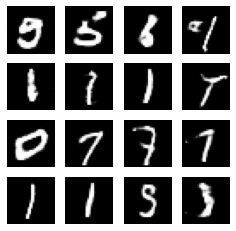

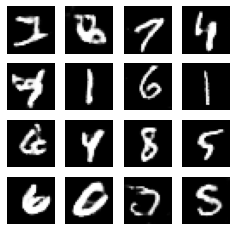

In [ ]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

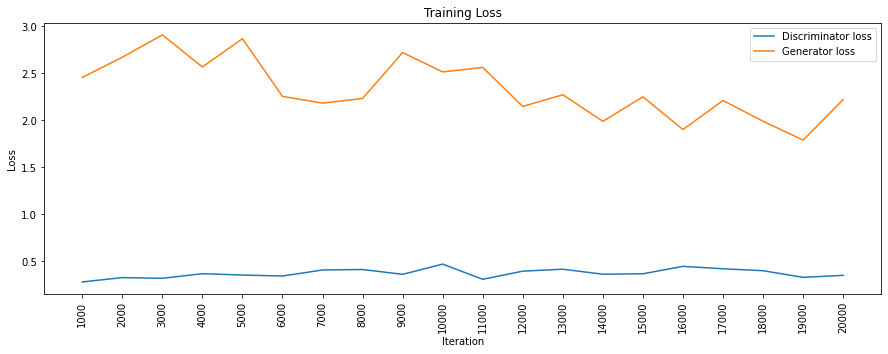

In [ ]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

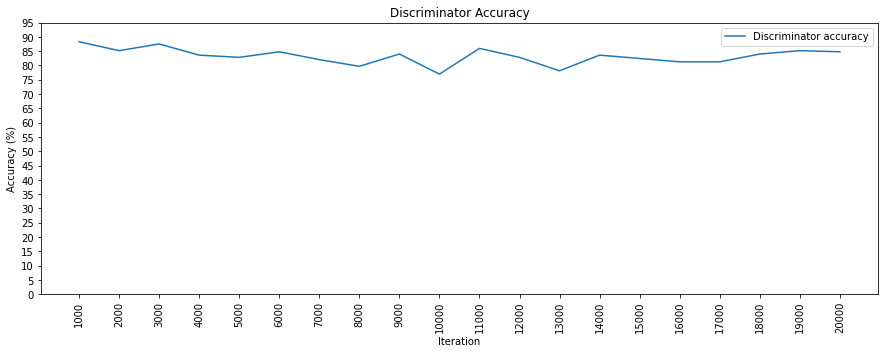

In [ ]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()